In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import time
import os

In [ ]:
OUTPUT_PATH = '/content/drive/MyDrive/processed_data'
preprocessing_info = np.load(os.path.join(OUTPUT_PATH, 'preprocessing_info.npy'),
                             allow_pickle=True).item()

IMG_SIZE = preprocessing_info['img_size']
NUM_CLASSES = preprocessing_info['num_classes']
CLASS_NAMES = preprocessing_info['class_names']
CLASS_WEIGHTS = preprocessing_info['class_weights']


print(f"Image Size: {IMG_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")
print(f"Using: ResNet50 pre-trained on ImageNet")


Image Size: (224, 224)
Number of Classes: 5
Classes: ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
Using: ResNet50 pre-trained on ImageNet


BUILD RESNET MODEL WITH TRANSFER LEARNING

In [ ]:
def build_resnet_transfer_learning(input_shape=(224, 224, 3), num_classes=5):


    # Load pre-trained ResNet50 (without top classification layer)
    print("\nLoading ResNet50 pre-trained on ImageNet...")
    base_model = ResNet50(
        weights='imagenet',  # Use ImageNet pre-trained weights
        include_top=False,   # Don't include the top classification layer
        input_shape=input_shape,
        pooling=None  # We'll add our own pooling
    )

    print(f"Base model loaded successfully!")
    print(f"Total layers in ResNet50: {len(base_model.layers)}")

    # Initially freeze all layers in the base model
    base_model.trainable = False
    print("Base model layers frozen (transfer learning mode)")

    # Build the complete model
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Pre-trained ResNet50 base
        base_model,

        # Global Average Pooling (better than flatten)
        layers.GlobalAveragePooling2D(name='global_avg_pool'),

        # Batch Normalization
        layers.BatchNormalization(name='bn1'),

        # Dense layer with dropout
        layers.Dense(512, activation='relu',
                    kernel_regularizer=l2(0.001),
                    name='dense1'),
        layers.Dropout(0.5, name='dropout1'),

        # Another dense layer
        layers.Dense(256, activation='relu',
                    kernel_regularizer=l2(0.001),
                    name='dense2'),
        layers.Dropout(0.3, name='dropout2'),

        # Output layer
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ], name='ResNet50_Transfer_Learning')

    return model, base_model

# Build the model
print("\nBuilding ResNet50 with transfer learning...")
resnet_model, base_resnet = build_resnet_transfer_learning(
    input_shape=(*IMG_SIZE, 3),
    num_classes=NUM_CLASSES
)

# Display model summary
print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
resnet_model.summary()

# Count parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in resnet_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {non_trainable_params:,}")
print(f"Percentage Trainable: {(trainable_params/total_params)*100:.2f}%")


Building ResNet50 with transfer learning...

Loading ResNet50 pre-trained on ImageNet...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Base model loaded successfully!
Total layers in ResNet50: 175
Base model layers frozen (transfer learning mode)

MODEL ARCHITECTURE SUMMARY


Model: "ResNet50_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,777,605 (94.52 MB)

 Trainable params: 1,185,797 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


Total Parameters: 24,777,605
Trainable Parameters: 1,185,797
Non-trainable Parameters: 23,591,808
Percentage Trainable: 4.79%


COMPILE MODEL

In [ ]:
# Use Adam optimizer for transfer learning
optimizer = optimizers.Adam(learning_rate=0.001)

resnet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Optimizer: Adam (lr=0.001)")
print("Loss: Sparse Categorical Crossentropy")
print("Metrics: Accuracy")
print("Base Model: Frozen (only training top layers)")

Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Metrics: Accuracy
Base Model: Frozen (only training top layers)


SETUP CALLBACKS

In [ ]:
# Create directory for saving models
model_save_path = '/content/drive/MyDrive/models/resnet_transfer'
os.makedirs(model_save_path, exist_ok=True)

# Callbacks
callbacks_list = [
    # Save best model
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_save_path, 'resnet_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # CSV logger
    callbacks.CSVLogger(
        os.path.join(model_save_path, 'training_log.csv'),
        append=False
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


PREPARE DATA GENERATORS

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

DATASET_PATH = '/content/drive/MyDrive/weather_dataset/dataset'
BATCH_SIZE = 32

# Load split data
X_train = np.load(os.path.join(OUTPUT_PATH, 'X_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(OUTPUT_PATH, 'X_val.npy'), allow_pickle=True)
X_test = np.load(os.path.join(OUTPUT_PATH, 'X_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join(OUTPUT_PATH, 'y_train.npy'), allow_pickle=True)
y_val = np.load(os.path.join(OUTPUT_PATH, 'y_val.npy'), allow_pickle=True)
y_test = np.load(os.path.join(OUTPUT_PATH, 'y_test.npy'), allow_pickle=True)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(datagen, X, y, batch_size, shuffle=True):
    df = pd.DataFrame({'filename': X, 'class': y.astype(str)})
    return datagen.flow_from_dataframe(
        dataframe=df, x_col='filename', y_col='class',
        target_size=IMG_SIZE, batch_size=batch_size,
        class_mode='sparse', shuffle=shuffle, seed=42
    )

train_generator = create_generator(train_datagen, X_train, y_train, BATCH_SIZE, True)
val_generator = create_generator(val_datagen, X_val, y_val, BATCH_SIZE, False)
test_generator = create_generator(test_datagen, X_test, y_test, BATCH_SIZE, False)

print(f"Training generator: {len(train_generator)} batches")
print(f"Validation generator: {len(val_generator)} batches")
print(f"Test generator: {len(test_generator)} batches")

Found 1050 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.
Training generator: 33 batches
Validation generator: 10 batches
Test generator: 5 batches


PHASE 1: TRAIN WITH FROZEN BASE

In [ ]:
EPOCHS_PHASE1 = 20

start_time_phase1 = time.time()

history_phase1 = resnet_model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=callbacks_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

time_phase1 = time.time() - start_time_phase1
print(f"\nPhase 1 training completed in {time_phase1/60:.2f} minutes")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.3528 - loss: 2.4726 
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 996s 30s/step - accuracy: 0.3557 - loss: 2.4645 - val_accuracy: 0.2000 - val_loss: 3.2168 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5862 - loss: 1.7610
Epoch 2: val_accuracy did not improve from 0.20000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 672ms/step - accuracy: 0.5868 - loss: 1.7597 - val_accuracy: 0.2000 - val_loss: 3.1419 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6249 - loss: 1.5509
Epoch 3: val_accuracy did not improve from 0.20000
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 682ms/step - accuracy: 0.6251 - loss: 1.5506 - val_accuracy: 0.2000 - val_loss: 3.0726 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6222 - loss: 1.5368
Epoch 4: val_accuracy did not improve from 0.20000
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.6225 - loss: 1.5357 - val_accuracy: 0.2000 - val_loss: 2.5114 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 760ms/step - accuracy: 0.6863 - loss: 1.4153 - val_accuracy: 0.2033 - val_loss: 2.4671 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6754 - loss: 1.4574
Epoch 6: val_accuracy improved from 0.20333 to 0.29667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 792ms/step - accuracy: 0.6758 - loss: 1.4562 - val_accuracy: 0.2967 - val_loss: 2.1188 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6909 - loss: 1.3409
Epoch 7: val_accuracy improved from 0.29667 to 0.45667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 792ms/step - accuracy: 0.6909 - loss: 1.3411 - val_accuracy: 0.4567 - val_loss: 1.9244 - learning_rate: 0.0010
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7125 - loss: 1.3184
Epoch 8: val_accuracy did not improve from 0.45667
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 772ms/step - accuracy: 0.7122 - loss: 1.3185 - val_accuracy: 0.4167 - val_loss: 1.8638 - learning_rate: 0.0010
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6978 - loss: 1.3471
Epoch 9: val_accuracy did not improve from 0.45667
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.6986 - loss: 1.3455 - val_accuracy: 0.4367 - val_loss: 1.7238 - learning_rate: 0.0010
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7620 - loss: 1.1808
Epoch 10: val_accuracy did not improve from 0.45667
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 665ms/step - accuracy: 0.7615 - loss: 1.1821 - val_accuracy: 0.4467 - val_loss: 1.6822 - learning_rate: 0.0010
Epoch 11/20
33/33 ━

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - accuracy: 0.6909 - loss: 1.3191 - val_accuracy: 0.6400 - val_loss: 1.4690 - learning_rate: 0.0010
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7119 - loss: 1.2149
Epoch 12: val_accuracy did not improve from 0.64000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 700ms/step - accuracy: 0.7123 - loss: 1.2148 - val_accuracy: 0.6133 - val_loss: 1.4363 - learning_rate: 0.0010
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7119 - loss: 1.2231
Epoch 13: val_accuracy improved from 0.64000 to 0.67667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 727ms/step - accuracy: 0.7121 - loss: 1.2219 - val_accuracy: 0.6767 - val_loss: 1.3251 - learning_rate: 0.0010
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7121 - loss: 1.1946
Epoch 14: val_accuracy improved from 0.67667 to 0.70000, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - accuracy: 0.7124 - loss: 1.1951 - val_accuracy: 0.7000 - val_loss: 1.2921 - learning_rate: 0.0010
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7211 - loss: 1.1899
Epoch 15: val_accuracy did not improve from 0.70000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 701ms/step - accuracy: 0.7208 - loss: 1.1899 - val_accuracy: 0.6733 - val_loss: 1.2887 - learning_rate: 0.0010
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7308 - loss: 1.1560
Epoch 16: val_accuracy improved from 0.70000 to 0.77333, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 752ms/step - accuracy: 0.7311 - loss: 1.1548 - val_accuracy: 0.7733 - val_loss: 1.1409 - learning_rate: 0.0010
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7588 - loss: 1.0800
Epoch 17: val_accuracy improved from 0.77333 to 0.81667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 789ms/step - accuracy: 0.7586 - loss: 1.0803 - val_accuracy: 0.8167 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7603 - loss: 1.1161
Epoch 18: val_accuracy did not improve from 0.81667
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 693ms/step - accuracy: 0.7600 - loss: 1.1167 - val_accuracy: 0.7700 - val_loss: 1.0747 - learning_rate: 0.0010
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7473 - loss: 1.1067
Epoch 19: val_accuracy did not improve from 0.81667
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 634ms/step - accuracy: 0.7465 - loss: 1.1081 - val_accuracy: 0.7500 - val_loss: 1.1059 - learning_rate: 0.0010
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7599 - loss: 1.0497
Epoch 20: val_accuracy did not improve from 0.81667
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 673ms/step - accuracy: 0.7597 - loss: 1.0506 - val_accuracy: 0.7600 - val_loss: 1.0872 - learning_rate: 0.0010
Restoring model

PHASE 2: FINE-TUNING

In [ ]:
# Unfreeze the last few layers of the base model for fine-tuning
base_resnet.trainable = True

# Freeze all layers except the last 30
print(f"Total layers in base model: {len(base_resnet.layers)}")
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

# Count trainable parameters after unfreezing
trainable_params_phase2 = sum([tf.size(w).numpy() for w in resnet_model.trainable_weights])
print(f"Trainable parameters after unfreezing: {trainable_params_phase2:,}")
print(f"Percentage trainable: {(trainable_params_phase2/total_params)*100:.2f}%")

# Recompile with lower learning rate for fine-tuning
optimizer_phase2 = optimizers.Adam(learning_rate=0.0001)  # Lower LR for fine-tuning

resnet_model.compile(
    optimizer=optimizer_phase2,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with lr=0.0001 for fine-tuning")

# Update callbacks for phase 2
callbacks_list_phase2 = [
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_save_path, 'resnet_best_finetuned.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.CSVLogger(
        os.path.join(model_save_path, 'finetuning_log.csv'),
        append=False
    )
]



Total layers in base model: 175
Trainable parameters after unfreezing: 15,635,973
Percentage trainable: 63.11%
Model recompiled with lr=0.0001 for fine-tuning


In [ ]:
# Continue training with fine-tuning
EPOCHS_PHASE2 = 30

start_time_phase2 = time.time()

history_phase2 = resnet_model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=callbacks_list_phase2,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

time_phase2 = time.time() - start_time_phase2
total_training_time = time_phase1 + time_phase2

print(f"\nPhase 2 (fine-tuning) completed in {time_phase2/60:.2f} minutes")
print(f"Total training time: {total_training_time/60:.2f} minutes")

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.5413 - loss: 1.9579
Epoch 1: val_accuracy improved from -inf to 0.23667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5428 - loss: 1.9506 - val_accuracy: 0.2367 - val_loss: 16.8996 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.6836 - loss: 1.3299
Epoch 2: val_accuracy improved from 0.23667 to 0.27333, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 890ms/step - accuracy: 0.6834 - loss: 1.3308 - val_accuracy: 0.2733 - val_loss: 10.6508 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7122 - loss: 1.2226
Epoch 3: val_accuracy improved from 0.27333 to 0.36000, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7122 - loss: 1.2225 - val_accuracy: 0.3600 - val_loss: 3.8651 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.7844 - loss: 1.0307
Epoch 4: val_accuracy did not improve from 0.36000
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 805ms/step - accuracy: 0.7838 - loss: 1.0320 - val_accuracy: 0.2233 - val_loss: 7.9793 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.7690 - loss: 1.0735
Epoch 5: val_accuracy did not improve from 0.36000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - accuracy: 0.7689 - loss: 1.0734 - val_accuracy: 0.3133 - val_loss: 11.1354 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.7676 - loss: 1.0723
Epoch 6: val_accuracy did not improve from 0.36000

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 666ms/step - accuracy: 0.7674 - loss: 1.0723 

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 878ms/step - accuracy: 0.7657 - loss: 1.0724 - val_accuracy: 0.4633 - val_loss: 4.4719 - learning_rate: 5.0000e-05
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8004 - loss: 0.9356
Epoch 8: val_accuracy improved from 0.46333 to 0.56333, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 934ms/step - accuracy: 0.8007 - loss: 0.9357 - val_accuracy: 0.5633 - val_loss: 2.8976 - learning_rate: 5.0000e-05
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.7898 - loss: 0.9456
Epoch 9: val_accuracy did not improve from 0.56333
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 822ms/step - accuracy: 0.7902 - loss: 0.9458 - val_accuracy: 0.4100 - val_loss: 3.3718 - learning_rate: 5.0000e-05
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7942 - loss: 0.9388
Epoch 10: val_accuracy did not improve from 0.56333
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - accuracy: 0.7944 - loss: 0.9388 - val_accuracy: 0.4367 - val_loss: 3.6424 - learning_rate: 5.0000e-05
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.8084 - loss: 0.9205
Epoch 11: val_accuracy did not improve from 0.56333

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - accuracy: 0.8087 - loss: 

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 948ms/step - accuracy: 0.8169 - loss: 0.8968 - val_accuracy: 0.7033 - val_loss: 1.4061 - learning_rate: 2.5000e-05
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.8407 - loss: 0.8656
Epoch 14: val_accuracy did not improve from 0.70333
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 890ms/step - accuracy: 0.8400 - loss: 0.8665 - val_accuracy: 0.6567 - val_loss: 1.3857 - learning_rate: 2.5000e-05
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8213 - loss: 0.8879
Epoch 15: val_accuracy did not improve from 0.70333
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 675ms/step - accuracy: 0.8216 - loss: 0.8877 - val_accuracy: 0.6900 - val_loss: 1.4691 - learning_rate: 2.5000e-05
Epoch 16/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8126 - loss: 0.8945
Epoch 16: val_accuracy did not improve from 0.70333
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 685ms/step - accuracy: 0.8129 - loss: 0.8940 - val_accuracy: 0.6967 - val_loss: 1.6990 - learning_rate: 2.5000e-05

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 897ms/step - accuracy: 0.8447 - loss: 0.8272 - val_accuracy: 0.7700 - val_loss: 1.0934 - learning_rate: 1.2500e-05
Epoch 19/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8602 - loss: 0.8143
Epoch 19: val_accuracy did not improve from 0.77000
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 811ms/step - accuracy: 0.8598 - loss: 0.8148 - val_accuracy: 0.7367 - val_loss: 1.2103 - learning_rate: 1.2500e-05
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8230 - loss: 0.8640
Epoch 20: val_accuracy did not improve from 0.77000
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - accuracy: 0.8234 - loss: 0.8632 - val_accuracy: 0.7100 - val_loss: 1.4402 - learning_rate: 1.2500e-05
Epoch 21/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8519 - loss: 0.8458
Epoch 21: val_accuracy improved from 0.77000 to 0.77667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 784ms/step - accuracy: 0.8518 - loss: 0.8452 - val_accuracy: 0.7767 - val_loss: 1.2171 - learning_rate: 1.2500e-05
Epoch 22/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.8450 - loss: 0.7891
Epoch 22: val_accuracy did not improve from 0.77667
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 812ms/step - accuracy: 0.8449 - loss: 0.7902 - val_accuracy: 0.7500 - val_loss: 1.2434 - learning_rate: 6.2500e-06
Epoch 23/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8547 - loss: 0.8082
Epoch 23: val_accuracy improved from 0.77667 to 0.78000, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 762ms/step - accuracy: 0.8548 - loss: 0.8088 - val_accuracy: 0.7800 - val_loss: 1.0702 - learning_rate: 6.2500e-06
Epoch 24/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.8750 - loss: 0.7960
Epoch 24: val_accuracy improved from 0.78000 to 0.81333, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 914ms/step - accuracy: 0.8744 - loss: 0.7973 - val_accuracy: 0.8133 - val_loss: 1.0576 - learning_rate: 6.2500e-06
Epoch 25/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8589 - loss: 0.7878
Epoch 25: val_accuracy improved from 0.81333 to 0.87667, saving model to /content/drive/MyDrive/models/resnet_transfer/resnet_best_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 854ms/step - accuracy: 0.8588 - loss: 0.7880 - val_accuracy: 0.8767 - val_loss: 0.8711 - learning_rate: 6.2500e-06
Epoch 26/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8524 - loss: 0.8297
Epoch 26: val_accuracy did not improve from 0.87667
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - accuracy: 0.8527 - loss: 0.8295 - val_accuracy: 0.8600 - val_loss: 0.8876 - learning_rate: 6.2500e-06
Epoch 27/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8698 - loss: 0.7902
Epoch 27: val_accuracy did not improve from 0.87667
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 690ms/step - accuracy: 0.8693 - loss: 0.7916 - val_accuracy: 0.8300 - val_loss: 0.9491 - learning_rate: 6.2500e-06
Epoch 28/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8476 - loss: 0.8155
Epoch 28: val_accuracy did not improve from 0.87667

Epoch 28: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.8478 - loss:

PLOT TRAINING HISTORY


Plotting training history...


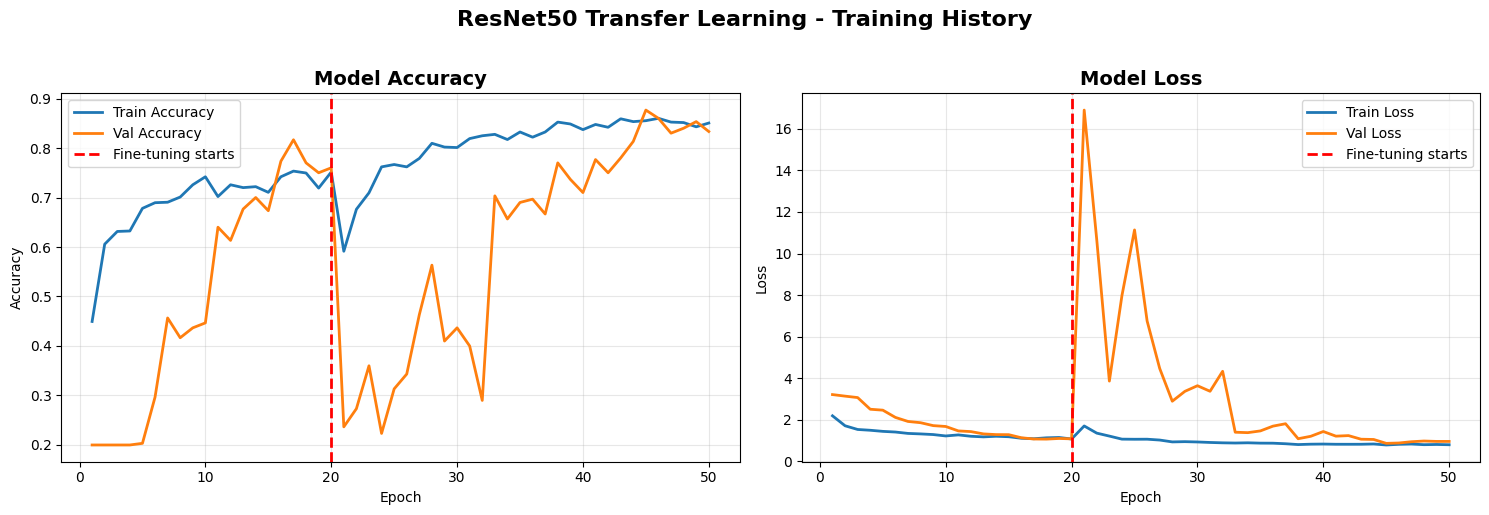

In [ ]:
def plot_training_history_phases(history1, history2, save_path):
    """Plot training history for both phases"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Combine histories
    epochs1 = len(history1.history['accuracy'])
    epochs2 = len(history2.history['accuracy'])
    total_epochs = epochs1 + epochs2

    train_acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    train_loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    # Accuracy plot
    axes[0].plot(range(1, total_epochs + 1), train_acc, label='Train Accuracy', linewidth=2)
    axes[0].plot(range(1, total_epochs + 1), val_acc, label='Val Accuracy', linewidth=2)
    axes[0].axvline(x=epochs1, color='red', linestyle='--', label='Fine-tuning starts', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(range(1, total_epochs + 1), train_loss, label='Train Loss', linewidth=2)
    axes[1].plot(range(1, total_epochs + 1), val_loss, label='Val Loss', linewidth=2)
    axes[1].axvline(x=epochs1, color='red', linestyle='--', label='Fine-tuning starts', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('ResNet50 Transfer Learning - Training History', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("\nPlotting training history...")
plot_training_history_phases(history_phase1, history_phase2,
                             os.path.join(model_save_path, 'training_history.png'))

EVALUATE ON TEST SET

In [ ]:
# Evaluate
test_results = resnet_model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")

# Get predictions
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = resnet_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Calculate additional metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 69s 17s/step - accuracy: 0.8470 - loss: 0.9129

Test Results:
  Loss: 0.8751
  Accuracy: 0.8667

Generating predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
  Precision: 0.8684
  Recall: 0.8667
  F1-Score: 0.8666


CONFUSION MATRIX

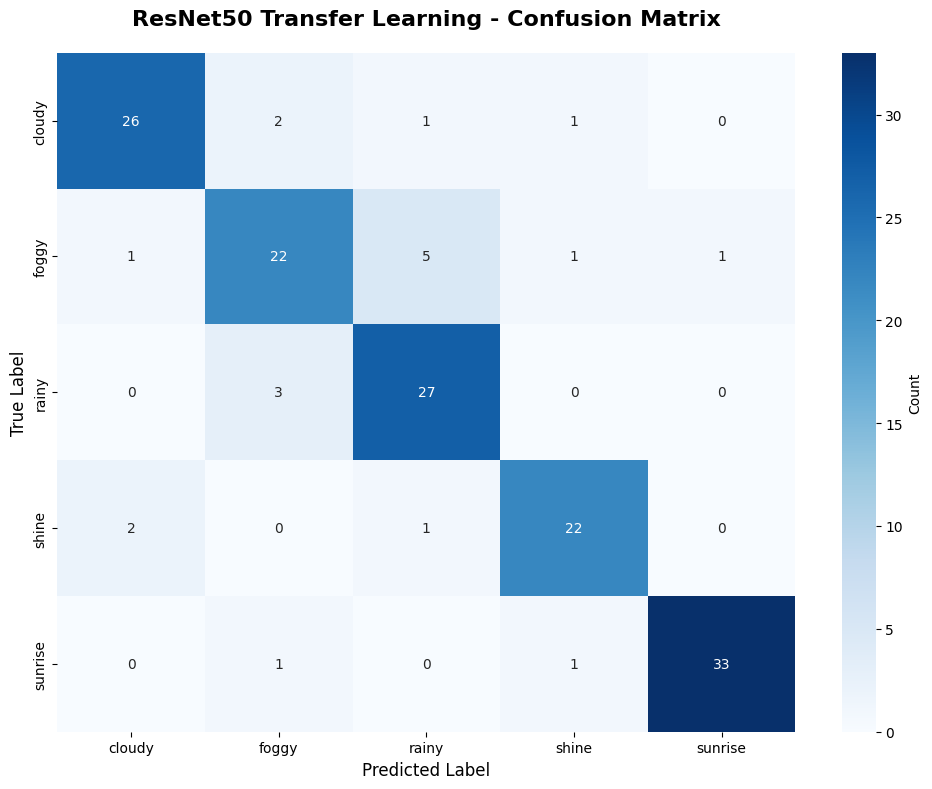

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('ResNet50 Transfer Learning - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

              precision    recall  f1-score   support

      cloudy     0.8966    0.8667    0.8814        30
       foggy     0.7857    0.7333    0.7586        30
       rainy     0.7941    0.9000    0.8438        30
       shine     0.8800    0.8800    0.8800        25
     sunrise     0.9706    0.9429    0.9565        35

    accuracy                         0.8667       150
   macro avg     0.8654    0.8646    0.8640       150
weighted avg     0.8684    0.8667    0.8666       150



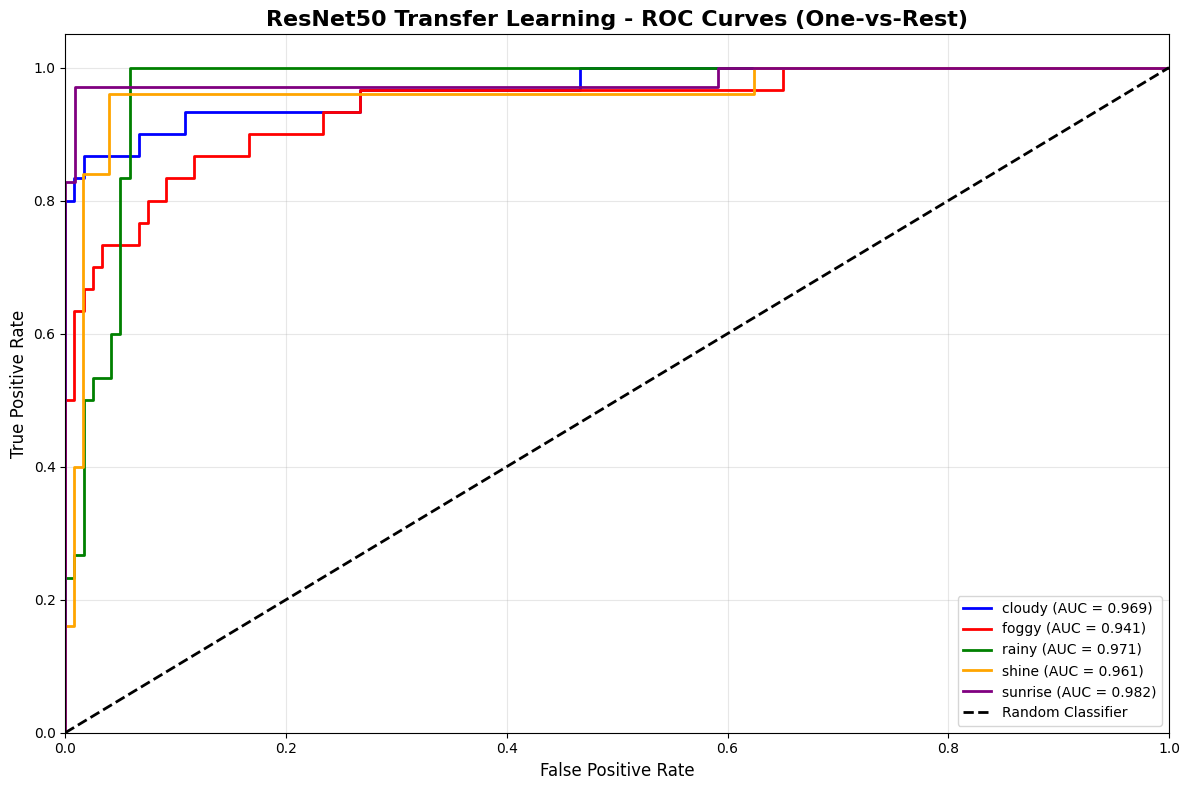


AUC Scores per Class:
  cloudy: 0.9689
  foggy: 0.9408
  rainy: 0.9708
  shine: 0.9613
  sunrise: 0.9819

Mean AUC: 0.9647


In [ ]:
# Binarize labels for ROC curve
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ResNet50 Transfer Learning - ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print AUC values
print("\nAUC Scores per Class:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {roc_auc[i]:.4f}")
print(f"\nMean AUC: {np.mean(list(roc_auc.values())):.4f}")

SAVE RESULTS

In [ ]:
results = {
    'model_name': 'ResNet50 Transfer Learning',
    'test_accuracy': float(test_accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1_score': float(f1),
    'test_loss': float(test_loss),
    'auc_scores': {CLASS_NAMES[i]: float(roc_auc[i]) for i in range(NUM_CLASSES)},
    'mean_auc': float(np.mean(list(roc_auc.values()))),
    'training_time_minutes': float(total_training_time/60),
    'phase1_time_minutes': float(time_phase1/60),
    'phase2_time_minutes': float(time_phase2/60),
    'total_params': int(total_params),
    'trainable_params_phase1': int(trainable_params),
    'trainable_params_phase2': int(trainable_params_phase2),
    'confusion_matrix': cm.tolist(),
    'class_names': CLASS_NAMES
}

np.save(os.path.join(model_save_path, 'results.npy'), results)

print("\n" + "="*70)
print("RESNET TRANSFER LEARNING COMPLETED!")
print("="*70)
print(f"Model saved to: {model_save_path}")
print(f"Results saved successfully!")
print("\nTransfer Learning Summary:")
print(f"  - Phase 1 (Frozen base): {EPOCHS_PHASE1} epochs, {time_phase1/60:.2f} min")
print(f"  - Phase 2 (Fine-tuning): {EPOCHS_PHASE2} epochs, {time_phase2/60:.2f} min")
print(f"  - Total training time: {total_training_time/60:.2f} min")
print(f"  - Final test accuracy: {test_accuracy:.4f}")
print("="*70)


RESNET TRANSFER LEARNING COMPLETED!
Model saved to: /content/drive/MyDrive/models/resnet_transfer
Results saved successfully!

Transfer Learning Summary:
  - Phase 1 (Frozen base): 20 epochs, 25.27 min
  - Phase 2 (Fine-tuning): 30 epochs, 13.46 min
  - Total training time: 38.73 min
  - Final test accuracy: 0.8667
